In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [2]:
from pyTVDN import TVDNDetect, TVDNRankTuning
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from pprint import pprint
import pickle
from easydict import EasyDict as edict
import warnings
from pyTVDN.TVDNutils import *
from pyTVDN.utils import in_notebook
if in_notebook():
    from tqdm import tqdm_notebook as tqdm
else:
    from tqdm import tqdm

class TVDNDetect1(TVDNDetect):
    def __init__(self, Ymat, ReconXmat, numStep=10, smoothType="Bspline", dataType=None, 
                 saveDir=None, showProgress=True, **paras):
        """
        Input:
            Ymat: The data matrix, d x n
            dataType: real data type, fMRI or MEG
            saveDir: Dir to save the results, if not specified, not save
            paras: Other parameters. There are default valuesi but you may specify these parameters manually.
               Inlcuding:
                    kappa: The parameter of penalty in MBIC
                    Lmin: The minimal length between 2 change points
                    r: The rank setted beforehand, in most cases, r=rAct. If we have non-complex singular values, r < rAct
                    MaxM: int, maximal number of change point 
                    lamb: The smooth parameter for B-spline
                    downRate: The downsample factor, determine how many Ai matrix to contribute to estimate the eigen values/vectors.
                    decimateRate: Mainly for MEG data. The rate to decimate from MEG data.
                    T: The time course
                    is_detrend: Whether detrend data or not
                    fct: The factor to adjust h when estimating A matrix
                    fName:  The file name when saving the results
                    plotfct: The factor to adjust the time course when plotting
                    freq: The parameter used drawing the eigen values plots
        """
        self.Ymat = Ymat
        self.paras = edict()
        if dataType is not None:
            self.dataType = dataType.lower()
        else:
            self.dataType = dataType

        if smoothType is not None:
            self.smoothType = smoothType.lower()
        else:
            self.smoothType = smoothType


        if self.dataType == "meg":
            self.paras.kappa = 2.65
            self.paras.Lmin = 60
            self.paras.r = 6
            self.paras.MaxM = 19
            self.paras.lamb = 1e-4
            self.paras.downRate = 20
            self.paras.decimateRate = 10
            self.paras.T = 2
            self.paras.is_detrend = False
            self.paras.fct = 0.5
            self.paras.fName = "MEG"
            self.paras.plotfct = 30
            self.paras.freq = 60
            self.paras.nbasis = 10
        elif self.dataType == "fmri":
            self.paras.kappa = 2.65
            self.paras.Lmin = 4
            self.paras.r = 6
            self.paras.MaxM = 10
            self.paras.lamb = 1e-4
            self.paras.downRate = 4
            self.paras.decimateRate = None
            self.paras.T = 2
            self.paras.is_detrend = False
            self.paras.fct = 0.5
            self.paras.fName = "fMRI"
            self.paras.plotfct = 180
            self.paras.freq = 0.5
            self.paras.nbasis = 10
        else:
            self.paras.kappa = 2.65
            self.paras.Lmin = 4
            self.paras.r = 6
            self.paras.MaxM = 19
            self.paras.lamb = 1e-6
            self.paras.downRate = 4
            self.paras.decimateRate = None
            self.paras.T = 2
            self.paras.is_detrend = False
            self.paras.fct = 1
            self.paras.fName = "simu"
            self.paras.plotfct = 1
            self.paras.freq = 180
            self.paras.nbasis = 10
        keys = list(self.paras.keys())
        for key in paras.keys():
            self.paras[key] = paras[key]
        if showProgress:
            print("The parameters for detection are:")
            pprint(self.paras)
        
        if saveDir is not None:
            self.saveDir = Path(saveDir)
            if not self.saveDir.exists():
                self.saveDir.mkdir()
        else:
            self.saveDir = saveDir
            
        self.numStep = numStep
        self.ReconXmat = ReconXmat
        self.showProgress = showProgress
        self.nYmat = None
        self.Xmat = None
        self.dXmat = None
        self.time = None
        self.midRes = None
        self.nXmat = None
        self.ndXmat = None
        self.Amat = None
        self.finalRes = None
        self.RecYmatAll = None
        self.RecResCur = None
        self.numchgs = None
        self.ecpts = None
        self.canpts = None
    
    
    def SmoothEst(self):
        if self.nYmat is None:
            self._Preprocess()
        d, n = self.nYmat.shape
        self.ptime = np.linspace(0, self.paras.T, n) * self.paras.plotfct
        self.time = np.linspace(0, self.paras.T, n)
        divNum = 100
        if self.smoothType == "bspline":
            self.dXmat = np.zeros((d, n))
            self.Xmat = np.zeros((d, n))
            if n%divNum == 0:
                numLoop = int(n/divNum)
            else:
                numLoop = int(n/divNum) + 1
            for i in range(numLoop):
                if (i+1)*divNum <= n:
                    low = i*divNum
                    up = (i+1)*divNum
                else:
                    low = i*divNum
                    up = n
                self.dXmat[:, low:up], self.Xmat[:, low:up] = GetBsplineEst(self.nYmat[:, low:up], self.time[low:up], lamb=self.paras.lamb)
        elif self.smoothType == "fourier":
            self.dXmat, self.Xmat = GetFourierEst(self.nYmat, self.time, nbasis=self.paras.nbasis)
            
    def GetRecResCur(self):
        numchg = len(self.ecpts)
        if self.RecYmatAll is not None:
            self.RecResCur = self.RecYmatAll[numchg]
        elif self.saveDir is not None:
            RecYmatAllPath = self.saveDir/f"{self.paras.fName}_Rank{self.paras.r}_RecAll.pkl"
            if RecYmatAllPath.exists():
                with open(RecYmatAllPath, "rb") as f:
                    self.RecYmatAll = pickle.load(f)
                self.RecResCur = self.RecYmatAll[numchg]
            else:
                MaxM = self.paras.MaxM
                r = self.paras.r
                finalRes = self.finalRes
                midRes = self.midRes
                _, n = midRes.nXmat.shape
                time = np.linspace(0, self.paras.T, n)
                tStep = np.diff(time)[0]
                ndXmat = midRes.ndXmat
                nXmat = midRes.nXmat
                kpidxs = midRes.kpidxs
                eigVecs = midRes.eigVecs
                self.RecResCur = self.ReconXmat(finalRes.chgMat[numchg-1, :numchg], ndXmat, nXmat, kpidxs, eigVecs, self.Xmat, 
                                                tStep, r=r, numStep=self.numStep, is_full=True) 
        else:
            MaxM = self.paras.MaxM
            r = self.paras.r
            finalRes = self.finalRes
            midRes = self.midRes
            _, n = midRes.nXmat.shape
            time = np.linspace(0, self.paras.T, n)
            tStep = np.diff(time)[0]
            ndXmat = midRes.ndXmat
            nXmat = midRes.nXmat
            kpidxs = midRes.kpidxs
            eigVecs = midRes.eigVecs
            self.RecResCur = self.ReconXmat(finalRes.chgMat[numchg-1, :numchg], ndXmat, nXmat, kpidxs, eigVecs, self.Xmat, 
                                            tStep, r=r, numStep=self.numStep, is_full=True) 
    
    def GetRecYmats(self):
        if self.RecYmatAll is None:
            RecYmatAll = []
            MaxM = self.paras.MaxM
            r = self.paras.r
            finalRes = self.finalRes
            midRes = self.midRes
            _, n = midRes.nXmat.shape
            time = np.linspace(0, self.paras.T, n)
            tStep = np.diff(time)[0]
            ndXmat = midRes.ndXmat
            nXmat = midRes.nXmat
            kpidxs = midRes.kpidxs
            eigVecs = midRes.eigVecs
            if self.showProgress:
                pbar = tqdm(range(MaxM+1))
                for numchg in pbar:
                    pbar.set_description(f"Kappa Tuning")
        #            print(f"Current number of change point is {numchg}.")
                    if numchg == 0:
                        RecResCur = self.ReconXmat([], ndXmat, nXmat, kpidxs, eigVecs, self.Xmat, tStep, r=r, numStep=self.numStep, is_full=True) 
                    else:
                        RecResCur = self.ReconXmat(finalRes.chgMat[numchg-1, :numchg], ndXmat, nXmat, kpidxs, eigVecs, self.Xmat, tStep, r=r, 
                                                   numStep=self.numStep, is_full=True) 
                    RecYmatAll.append(RecResCur)
            else:
                for numchg in range(MaxM+1):
                    if numchg == 0:
                        RecResCur = self.ReconXmat([], ndXmat, nXmat, kpidxs, eigVecs, self.Xmat, tStep, r=r, numStep=self.numStep, is_full=True) 
                    else:
                        RecResCur = self.ReconXmat(finalRes.chgMat[numchg-1, :numchg], ndXmat, nXmat, kpidxs, eigVecs, self.Xmat,
                                                   tStep, r=r, numStep=self.numStep, is_full=True) 
                    RecYmatAll.append(RecResCur)
            self.RecYmatAll = RecYmatAll
    
    
    def PlotRecCurve1(self, is_est=True, numP=3000, idxs=None, bestK=None, quantiles=None, saveFigPath=None, is_imag=False, is_bsp=False):
        """
        idxs: The indices of the sequences to plot 
        bestK: The best K fitted curves to plot according to the errors
        quantiles: The fitted sequences to plot according to the quantiles of errors.
        (priority: idxs > bestK > quantiles)_
        """
        assert self.finalRes is not None, "Run main function first!"
        if idxs is not None and (bestK is not None or quantiles is not None):
            warnings.warn("idxs is provided, so bestK or quantiles will be ignored", UserWarning)
        if idxs is None and bestK is not None and quantiles is not None:
            warnings.warn("bestK is provided, so quantiles will be ignored", UserWarning)
        if self.RecResCur is None:
            self.GetRecResCur()
        if is_imag:
            RecYmatCur = self.RecResCur.EstXmatImag
        else:
            RecYmatCur = self.RecResCur.EstXmatReal
        d, n = self.nYmat.shape
        if idxs is not None:
            assert d>=np.max(idxs) & np.min(idxs)>=0, "Wrong index!"
        else:
            diff = RecYmatCur - self.nYmat
            errs2 = np.sum(diff**2, axis=1)/np.sum(self.nYmat**2, axis=1)
            errs = np.sqrt(errs2)
            argidxs = np.argsort(errs)
            if quantiles is None and bestK is None:
                qidxs = np.quantile(np.arange(d), [0, 0.25, 0.5, 0.75, 1]).astype(np.int)
            elif bestK is not None:
                qidxs = argidxs[:bestK]
            else:
                qidxs = np.quantile(np.arange(d), quantiles).astype(np.int)
            idxs = argidxs[qidxs]
        if self.showProgress:
            print(f"The plot indices are {idxs}.")
        
        
        numSubPlot = len(idxs)
        numRow = ((numSubPlot-1) // 3) + 1
        
        plt.figure(figsize=[15, 5*numRow])

        for i, idx, in enumerate(idxs):
            plt.subplot(numRow, 3, i+1)
            if not is_imag:
                plt.plot(self.ptime[:numP], self.nYmat[idx, :numP], "-", label="Observed")
            if is_est:
                plt.plot(self.ptime[:numP], RecYmatCur[idx, :numP], "-.", label="Reconstructed")
            if is_bsp:
                if self.Xmat is None:
                    self.SmoothEst()
                plt.plot(self.ptime[:numP], self.Xmat[idx, :numP], "r--", label="B-spline Estimator")
            plt.legend()
        if saveFigPath is None:
            plt.show() 
        else:
            plt.savefig(saveFigPath)
            
        return idxs

In [4]:
# Reconstruct Xmat from results
def ReconXmatNew(ecpts, ndXmat, nXmat, kpidxs, eigVecs, Ymat, tStep, r, is_full=False):
    """
    Input: 
        ecpts: Estimated change points, 
        ndXmat: a rAct x n matrix
        nXmat: a rAct x n matrix
        kpidxs: The intermedian output when calculating ndXmat, nXmat
        eigVecs: The matrix of eigen vectors of A matrix, d x d
        Ymat: The matrix to construct, d x n 
        tStep: The time step
        r: The rank setted beforehand, in most cases, r=rAct. If we have non-complex singular values, r < rAct
        if_full: Where outputing full info or not

    Return:
        Estimated Xmat, d x n
    """
    print(f"The class calls the new reconstruction function, ReconXmatNew")
    rAct, n = ndXmat.shape
    d, _ = Ymat.shape
    ecptsfull = np.concatenate(([0], ecpts, [n])) - 1
    ecptsfull = ecptsfull.astype(np.int)
    numchgfull = len(ecptsfull)

    ResegS = np.zeros((numchgfull-1, r), dtype=np.complex)
    for  itr in range(numchgfull-1):
        lower = ecptsfull[itr] + 1
        upper = ecptsfull[itr+1] + 1
        Ycur = ndXmat[:, lower:upper]
        Xcur = nXmat[:, lower:upper]
        lams = np.zeros(r, dtype=np.complex) + np.inf
        for j in range(int(rAct/2)):
            tY = Ycur[(2*j):(2*j+2), :]
            tX = Xcur[(2*j):(2*j+2), :]
            corY = tY.dot(tX.T)
            corX = np.trace(tX.dot(tX.T))
            a = np.trace(corY)/corX
            b = (corY[1, 0] - corY[0, 1])/corX
            lams[kpidxs[j]] = a + b*1j
        tmpIdx = np.where(lams==np.inf)[0]
        lams[tmpIdx] = np.conjugate(lams[tmpIdx-1])
        ResegS[itr, :] = lams
    
    LamMs = np.zeros((r, n), dtype=np.complex)
    LamMs[:, 0] = ResegS[0, :]
    for itr in range(1, numchgfull):
        lower = ecptsfull[itr-1] + 1
        upper = ecptsfull[itr] + 1
        LamMs[:, lower:upper] = ResegS[itr-1, ].reshape(-1, 1)
    
    EstXmat = np.zeros((d, n), dtype=np.complex)
    EstXmat[:, 0] = Ymat[:, 0]
    invEigVecsr = inv(eigVecs)[:r, :]
    eigVecsr = eigVecs[:, :r]
    for i in range(1, n):
        if i in ecpts:
            EstXmat[:, i] = Ymat[:, i]
        else:
            mTerm = np.diag(LamMs[:, i])
            rTerm = invEigVecsr.dot(EstXmat[:, i-1])
            EstXmat[:, i] = eigVecsr.dot(mTerm).dot(rTerm) * tStep + EstXmat[:,i-1]
        
    if is_full:
        ReDict = edict()
        ReDict.EstXmatReal = detrend(EstXmat.real)
        ReDict.EstXmatRealOrg = EstXmat.real
        ReDict.EstXmatImag = EstXmat.imag
        ReDict.LamMs = LamMs
        return ReDict
    else:
        return detrend(EstXmat.real)

In [5]:
from scipy.linalg import expm
# Reconstruct with Exp form
def ReconXmatNewBspStep(ecpts, ndXmat, nXmat, kpidxs, eigVecs, Ymat, tStep, r, numStep=30, is_full=False):
    """
    Input: 
        ecpts: Estimated change points, 
        ndXmat: a rAct x n matrix
        nXmat: a rAct x n matrix
        kpidxs: The intermedian output when calculating ndXmat, nXmat
        eigVecs: The matrix of eigen vectors of A matrix, d x d
        Ymat: The matrix to construct, d x n 
        tStep: The time step
        r: The rank setted beforehand, in most cases, r=rAct. If we have non-complex singular values, r < rAct
        if_full: Where outputing full info or not

    Return:
        Estimated Xmat, d x n
    """
    print(f"The class calls the new reconstruction function, ReconXmatNewBspStep")
    rAct, n = ndXmat.shape
    d, _ = Ymat.shape
    ecptsfull = np.concatenate(([0], ecpts, [n])) - 1
    ecptsfull = ecptsfull.astype(np.int)
    numchgfull = len(ecptsfull)

    ResegS = np.zeros((numchgfull-1, r), dtype=np.complex)
    for  itr in range(numchgfull-1):
        lower = ecptsfull[itr] + 1
        upper = ecptsfull[itr+1] + 1
        Ycur = ndXmat[:, lower:upper]
        Xcur = nXmat[:, lower:upper]
        lams = np.zeros(r, dtype=np.complex) + np.inf
        for j in range(int(rAct/2)):
            tY = Ycur[(2*j):(2*j+2), :]
            tX = Xcur[(2*j):(2*j+2), :]
            corY = tY.dot(tX.T)
            corX = np.trace(tX.dot(tX.T))
            a = np.trace(corY)/corX
            b = (corY[1, 0] - corY[0, 1])/corX
            lams[kpidxs[j]] = a + b*1j
        tmpIdx = np.where(lams==np.inf)[0]
        lams[tmpIdx] = np.conjugate(lams[tmpIdx-1])
        ResegS[itr, :] = lams
    
    LamMs = np.zeros((r, n), dtype=np.complex)
    LamMs[:, 0] = ResegS[0, :]
    for itr in range(1, numchgfull):
        lower = ecptsfull[itr-1] + 1
        upper = ecptsfull[itr] + 1
        LamMs[:, lower:upper] = ResegS[itr-1, ].reshape(-1, 1)
    
    EstXmat = np.zeros((d, n), dtype=np.complex)
    EstXmat[:, 0] = Ymat[:, 0]
    invEigVecsr = inv(eigVecs)[:r, :]
    eigVecsr = eigVecs[:, :r]
    Amats = []
    for i in range(1, n):
        LamMat = np.diag(LamMs[:, i])
        Amat = eigVecsr.dot(LamMat).dot(invEigVecsr)
        Amats.append(Amat)
        if i%numStep==0:
            #EstXmat[:, i] = expm(Amat*tStep).dot(Ymat[:,i-1])
            EstXmat[:, i] = Amat.dot(Ymat[:, i-1]) * tStep + Ymat[:,i-1]
        else:
            #EstXmat[:, i] = expm(Amat*tStep).dot(EstXmat[:,i-1])
            EstXmat[:, i] = Amat.dot(EstXmat[:, i-1]) * tStep + EstXmat[:,i-1]
    if is_full:
        ReDict = edict()
        ReDict.EstXmatReal = detrend(EstXmat.real)
        ReDict.EstXmatRealOrg = EstXmat.real
        ReDict.EstXmatImag = EstXmat.imag
        ReDict.LamMs = LamMs
        ReDict.Amats = Amats
        return ReDict
    else:
        return detrend(EstXmat.real)

In [6]:
resDir = Path("../results")
dataDir = Path("../data")

In [7]:
filname = Path("subj1.mat")
MEG = loadmat(dataDir/filname)["DK_timecourse"]

## Data Preprocessing

### 1. Decimate (Subsample)

In [8]:
from scipy.signal import lfilter, firls, decimate

In [9]:
MEG = decimate(MEG, q=5)

### 2.HPF 

In [10]:
fs = 120 #sampling frequency
fmin = 2 # 2Hz - 45Hz signal range, filter for this with hbp
fmax = 45
hbp = firls(101, np.array([0, 0.2*fmin, 0.9*fmin, fmax-2, fmax+5, 60])*2/fs,
           desired = np.array([0, 0, 1, 1, 0, 0])) #for detrending, a bandpass
hpfMEG = lfilter(hbp, 1, MEG)

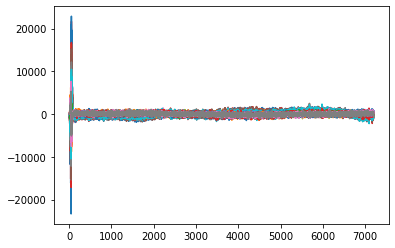

In [11]:
for i in range(68):
    plt.plot(hpfMEG[i, :])

In [12]:
hpfMEGEdgeRM = hpfMEG[:, 100:-100]

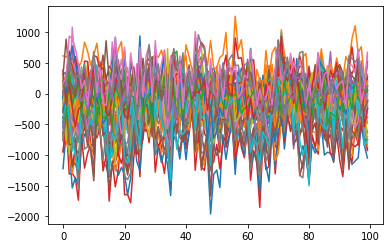

In [13]:
for i in range(68):
    plt.plot(hpfMEGEdgeRM[i, :100])

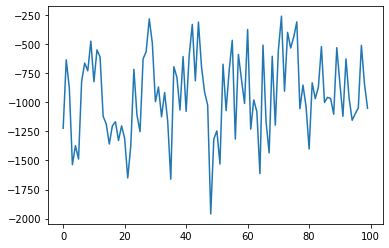

In [14]:
plt.plot(hpfMEGEdgeRM[10, :100])

In [15]:
smallMEG = hpfMEGEdgeRM[:, :500]

# 1.  Screening vs Non-Screening

## Screening

In [16]:
MEGBspDetSmall = TVDNDetect1(Ymat=smallMEG, ReconXmat=ReconXmatNewBspStep, numStep=1, 
                        saveDir=None, dataType="MEG", Lmin=4, downRate=5, fct=1, T=2, 
                        fName="subj1_HPF_small", r=10, kappa=2.65, freq=120, lamb=1e-6, decimateRate=None, is_detrend=True)

The parameters for detection are:
{'Lmin': 4,
 'MaxM': 19,
 'T': 2,
 'decimateRate': None,
 'downRate': 5,
 'fName': 'subj1_HPF_small',
 'fct': 1,
 'freq': 120,
 'is_detrend': True,
 'kappa': 2.65,
 'lamb': 1e-06,
 'nbasis': 10,
 'plotfct': 30,
 'r': 10}


In [20]:
MEGBspDetSmall.Screening(wh=5)

In [21]:
MEGBspDetSmall()


The class calls the new reconstruction function, ReconXmatNewBspStep


## Tuning the kappa parameters

In [22]:
kappas = np.arange(0.01, 4, 0.01)
MEGBspDetSmall.TuningKappa(kappas)

The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruc

In [23]:
print("The optimal kappas are:", MEGBspDetSmall.optKappa)
print("The optimal number of change point under the range of kappa we speicified is:", MEGBspDetSmall.optKappaOptNumChg)
print("The optimal number of change point is:", MEGBspDetSmall.optNumChg)

The optimal kappas are: 1.24
The optimal number of change point under the range of kappa we speicified is: 17
The optimal number of change point is: 15


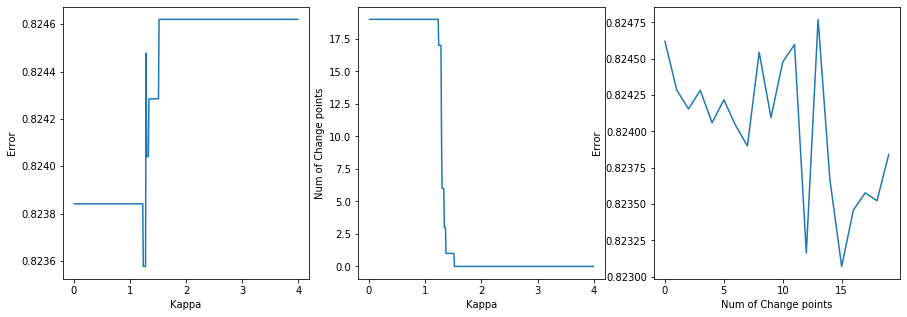

In [25]:
MEGBspDetSmall.PlotKappaErrCurve()

In [27]:
MEGBspDetSmall.UpdateEcpts()

In [29]:
print(MEGBspDetSmall)

+-------------+------------------------------------------------------------------------+--------------------+------+
| Num of CPTs |                             Estiamted CPTs                             |        MSE         | Rank |
+-------------+------------------------------------------------------------------------+--------------------+------+
|      17     | [ 15.  21.  36.  45.  54.  63.  73.  80. 285. 291. 300. 404. 409. 417. | 0.8235768577307011 |  10  |
|             |                             429. 436. 495.]                            |                    |      |
+-------------+------------------------------------------------------------------------+--------------------+------+


The plot indices are [41 33 37 35 19].


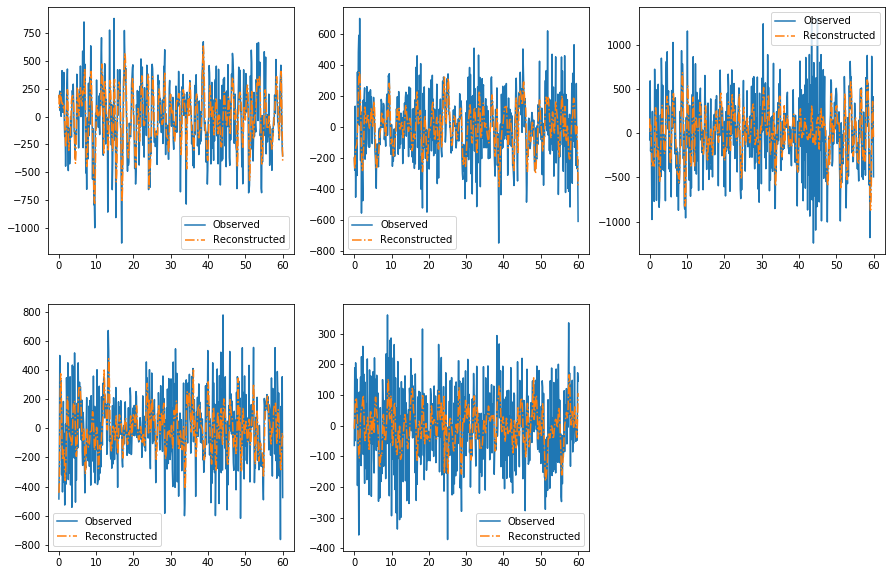

In [31]:
idxs = MEGBspDetSmall.PlotRecCurve(is_smoothCurve=0, saveFigPath=None)

#### Restrict Y axis and No detrend

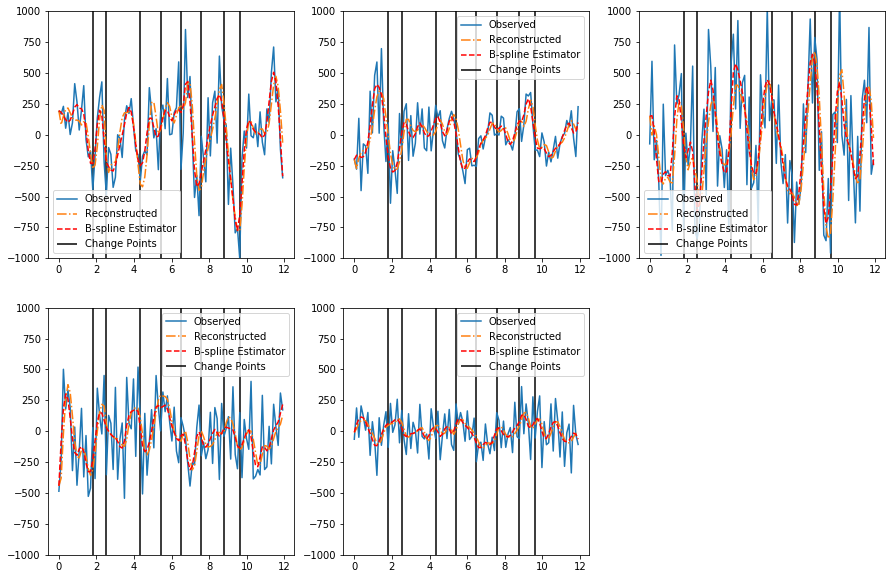

In [42]:
low = 0
up = 100
ecpts = MEGBspDetSmall.ecpts
ecpts = ecpts[ecpts>=low]
ecpts = ecpts[ecpts<=up]
ecpts = ecpts - low
ecpts = ecpts.astype(np.int)
plt.figure(figsize=[15, 5*2])
for i, idx, in enumerate(idxs):
    plt.subplot(2, 3, i+1)
    plt.ylim([-1000, 1000])
    plt.plot(MEGBspDetSmall.ptime[low:up], MEGBspDetSmall.nYmat[idx, low:up], "-", label="Observed")
    plt.plot(MEGBspDetSmall.ptime[low:up], MEGBspDetSmall.RecResCur.EstXmatRealOrg[idx, low:up], "-.", label="Reconstructed")
    plt.plot(MEGBspDetSmall.ptime[low:up], MEGBspDetSmall.Xmat[idx, low:up], "r--", label="B-spline Estimator")
    plt.vlines(MEGBspDetSmall.ptime[low:up][ecpts], ymin=-1000, ymax=1000, label="Change Points")
    plt.legend()

### Non-Screening

In [43]:
MEGBspDetSmallNon = TVDNDetect1(Ymat=smallMEG, ReconXmat=ReconXmatNewBspStep, numStep=1, 
                        saveDir=None, dataType="MEG", Lmin=4, downRate=5, fct=1, T=2, 
                        fName="subj1_HPF_small", r=10, kappa=2.65, freq=120, lamb=1e-6, decimateRate=None, is_detrend=True)

The parameters for detection are:
{'Lmin': 4,
 'MaxM': 19,
 'T': 2,
 'decimateRate': None,
 'downRate': 5,
 'fName': 'subj1_HPF_small',
 'fct': 1,
 'freq': 120,
 'is_detrend': True,
 'kappa': 2.65,
 'lamb': 1e-06,
 'nbasis': 10,
 'plotfct': 30,
 'r': 10}


In [45]:
MEGBspDetSmallNon()


The class calls the new reconstruction function, ReconXmatNewBspStep


## Tuning the kappa parameters

In [46]:
kappas = np.arange(0.01, 4, 0.01)
MEGBspDetSmallNon.TuningKappa(kappas)

The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruc

In [47]:
print("The optimal kappas are:", MEGBspDetSmallNon.optKappa)
print("The optimal number of change point under the range of kappa we speicified is:", MEGBspDetSmallNon.optKappaOptNumChg)
print("The optimal number of change point is:", MEGBspDetSmallNon.optNumChg)

The optimal kappas are: 0.01
The optimal number of change point under the range of kappa we speicified is: 19
The optimal number of change point is: 19


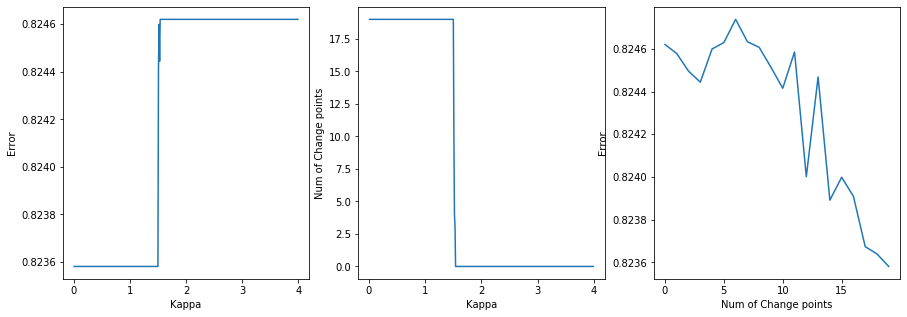

In [48]:
MEGBspDetSmallNon.PlotKappaErrCurve()

In [49]:
MEGBspDetSmallNon.UpdateEcpts(17)

In [50]:
print(MEGBspDetSmallNon)

+-------------+------------------------------------------------------------------------+--------------------+------+
| Num of CPTs |                             Estiamted CPTs                             |        MSE         | Rank |
+-------------+------------------------------------------------------------------------+--------------------+------+
|      17     | [  5.  11.  17.  23.  29.  35.  40.  45.  51.  57.  63.  69.  74.  80. | 0.8236739664744267 |  10  |
|             |                             482. 488. 494.]                            |                    |      |
+-------------+------------------------------------------------------------------------+--------------------+------+


The plot indices are [41 33 37 35 19].


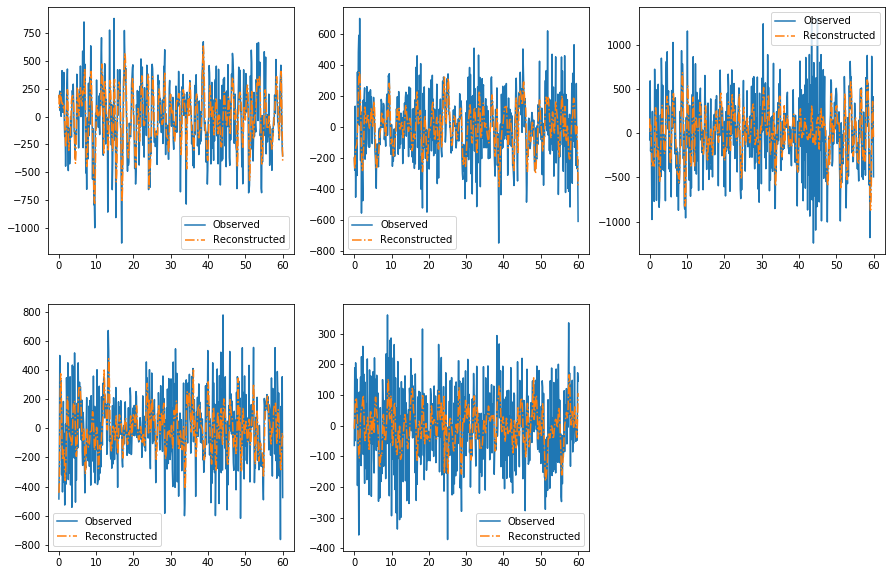

array([41, 33, 37, 35, 19])

In [51]:
MEGBspDetSmall.PlotRecCurve(idxs=idxs, is_smoothCurve=0, saveFigPath=None)

#### Restrict Y axis and No detrend

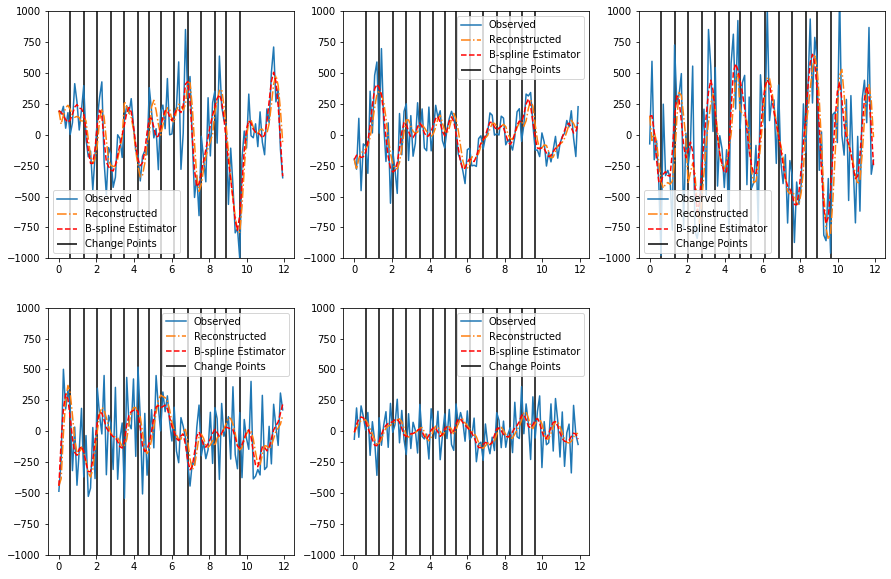

In [52]:
low = 0
up = 100
ecpts = MEGBspDetSmallNon.ecpts
ecpts = ecpts[ecpts>=low]
ecpts = ecpts[ecpts<=up]
ecpts = ecpts - low
ecpts = ecpts.astype(np.int)
plt.figure(figsize=[15, 5*2])
for i, idx, in enumerate(idxs):
    plt.subplot(2, 3, i+1)
    plt.ylim([-1000, 1000])
    plt.plot(MEGBspDetSmallNon.ptime[low:up], MEGBspDetSmallNon.nYmat[idx, low:up], "-", label="Observed")
    plt.plot(MEGBspDetSmallNon.ptime[low:up], MEGBspDetSmallNon.RecResCur.EstXmatRealOrg[idx, low:up], "-.", label="Reconstructed")
    plt.plot(MEGBspDetSmallNon.ptime[low:up], MEGBspDetSmallNon.Xmat[idx, low:up], "r--", label="B-spline Estimator")
    plt.vlines(MEGBspDetSmallNon.ptime[low:up][ecpts], ymin=-1000, ymax=1000, label="Change Points")
    plt.legend()

### Comparison

The difference of the reconstructed curve

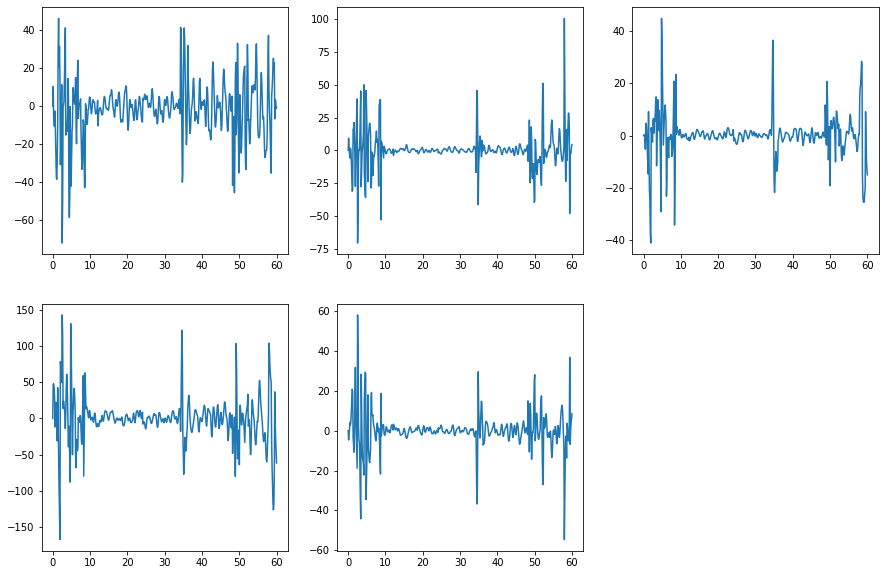

In [61]:
recDiff = MEGBspDetSmall.RecResCur.EstXmatRealOrg - MEGBspDetSmallNon.RecResCur.EstXmatRealOrg
ptime = MEGBspDetSmall.ptime
plt.figure(figsize=[15, 5*2])
for i, idx, in enumerate(idxs):
    plt.subplot(2, 3, i+1)
    plt.plot(ptime, recDiff[i, :])

# 2. Dection  with new model

In the model, $y=\frac{X_t-X_{t-1}}{dt}$

In [64]:
MEGBspDetNM = TVDNDetect1(Ymat=smallMEG, ReconXmat=ReconXmatNewBspStep, numStep=1, 
                        saveDir=None, dataType="MEG", Lmin=4, downRate=5, fct=1, T=2, 
                        fName="subj1_HPF_EdgeRM_6", r=10, kappa=2.65, freq=120, 
                          lamb=1e-6, decimateRate=None, is_detrend=True)

The parameters for detection are:
{'Lmin': 4,
 'MaxM': 19,
 'T': 2,
 'decimateRate': None,
 'downRate': 5,
 'fName': 'subj1_HPF_EdgeRM_6',
 'fct': 1,
 'freq': 120,
 'is_detrend': True,
 'kappa': 2.65,
 'lamb': 1e-06,
 'nbasis': 10,
 'plotfct': 30,
 'r': 10}


In [65]:
MEGBspDetNM.SmoothEst()

In [66]:
deltaT = np.diff(MEGBspDetNM.time)[0]
dXmatP = (MEGBspDetNM.Xmat[:, 1:] - MEGBspDetNM.Xmat[:, :-1])/deltaT

In [70]:
dXmat = np.zeros((68, 500))
lastC = dXmatP.mean(axis=1).reshape(1, -1)
dXmat[:, :-1] = dXmatP
dXmat[:, -1] = lastC

In [72]:
MEGBspDetNM.dXmat = dXmat

In [73]:
MEGBspDetNM()


The class calls the new reconstruction function, ReconXmatNewBspStep


## Tuning the kappa parameters

In [74]:
kappas = np.arange(0.01, 4, 0.01)
MEGBspDetNM.TuningKappa(kappas)

The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruc

In [75]:
print("The optimal kappas are:", MEGBspDetNM.optKappa)
print("The optimal number of change point under the range of kappa we speicified is:", MEGBspDetNM.optKappaOptNumChg)
print("The optimal number of change point is:", MEGBspDetNM.optNumChg)

The optimal kappas are: 1.55
The optimal number of change point under the range of kappa we speicified is: 0
The optimal number of change point is: 0


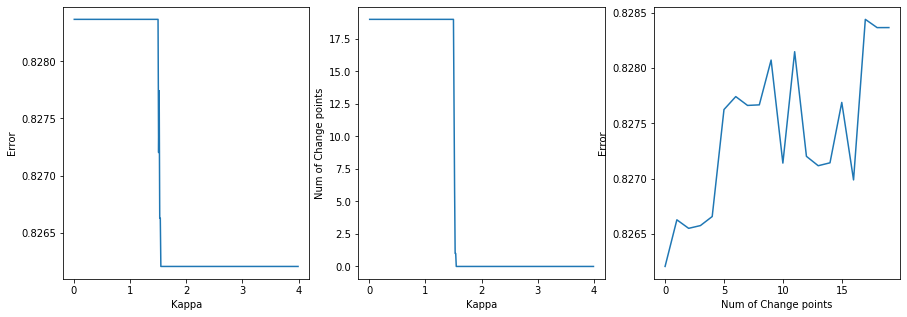

In [76]:
MEGBspDetNM.PlotKappaErrCurve()

##  Results when number of change point is 0

In [77]:
MEGBspDetNM.UpdateEcpts(numChg=5)

In [78]:
print(MEGBspDetNM)

+-------------+-----------------------+--------------------+------+
| Num of CPTs |     Estiamted CPTs    |        MSE         | Rank |
+-------------+-----------------------+--------------------+------+
|      5      | [ 6. 12. 18. 24. 30.] | 0.8276257840610624 |  10  |
+-------------+-----------------------+--------------------+------+


The plot indices are [41 25 60 42 38].


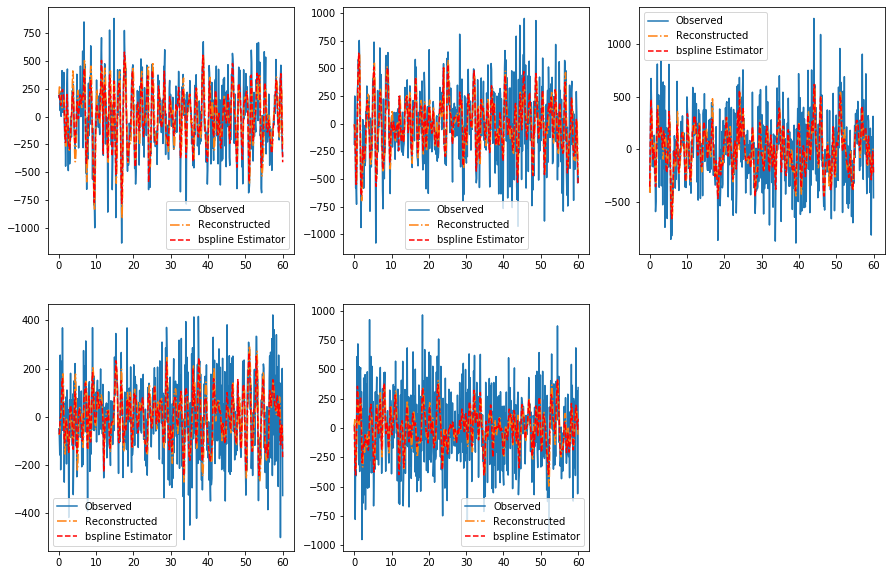

In [79]:
idxs = MEGBspDetNM.PlotRecCurve(is_smoothCurve=1, saveFigPath=None)

#### Restrict Y axis and No detrend

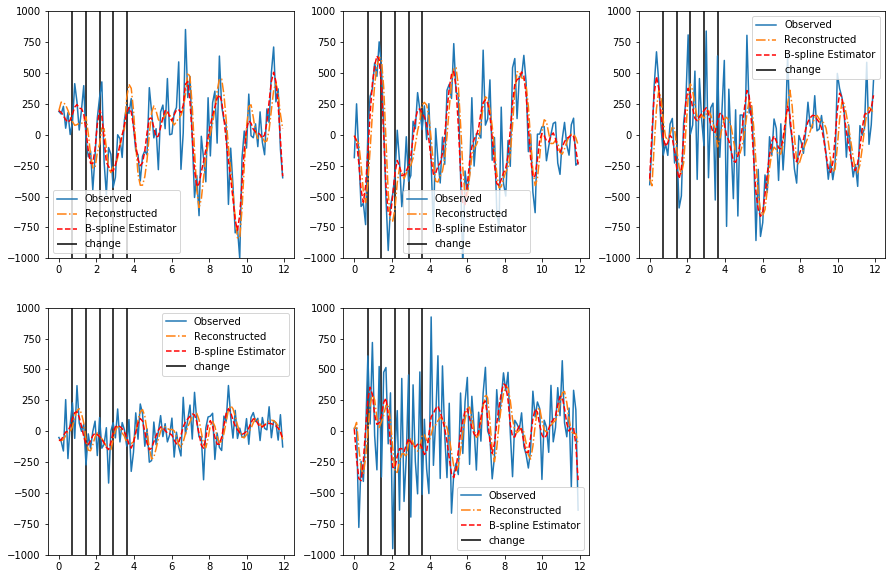

In [80]:
low = 0
up = 100
ecpts = MEGBspDetNM.ecpts
ecpts = ecpts[ecpts>=low]
ecpts = ecpts[ecpts<=up]
ecpts = ecpts - low
ecpts = ecpts.astype(np.int)
plt.figure(figsize=[15, 5*2])
for i, idx, in enumerate(idxs):
    plt.subplot(2, 3, i+1)
    plt.ylim([-1000, 1000])
    plt.plot(MEGBspDetNM.ptime[low:up], MEGBspDetNM.nYmat[idx, low:up], "-", label="Observed")
    plt.plot(MEGBspDetNM.ptime[low:up], MEGBspDetNM.RecResCur.EstXmatRealOrg[idx, low:up], "-.", label="Reconstructed")
    plt.plot(MEGBspDetNM.ptime[low:up], MEGBspDetNM.Xmat[idx, low:up], "r--", label="B-spline Estimator")
    plt.vlines(MEGBspDetNM.ptime[low:up][ecpts], ymin=-1000, ymax=1000, label="change")
    plt.legend()

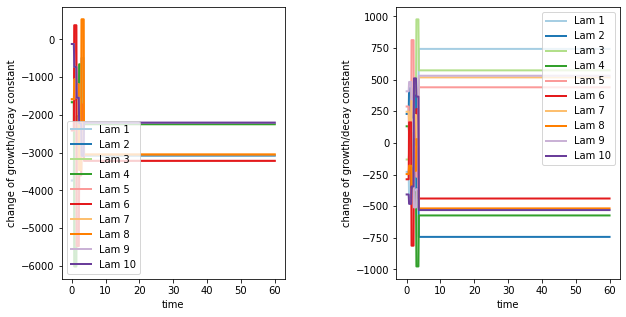

In [81]:
MEGBspDetNM.PlotEigenCurve()